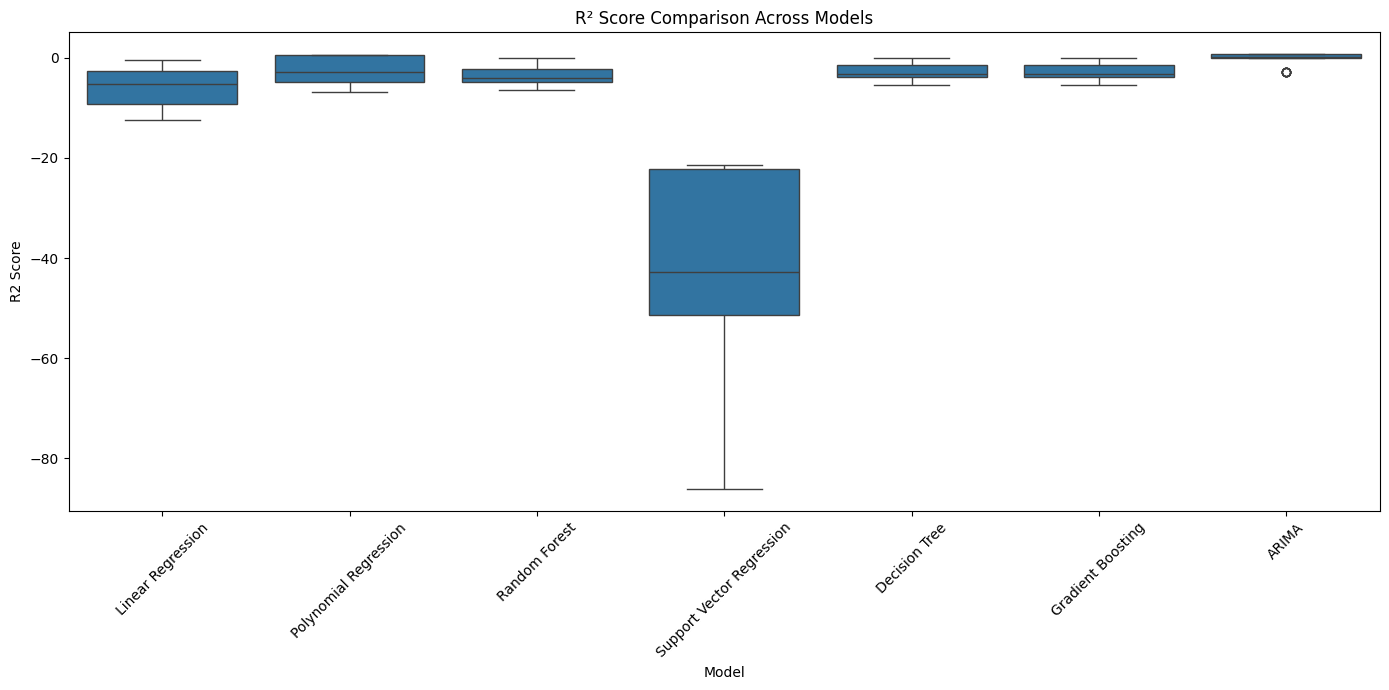

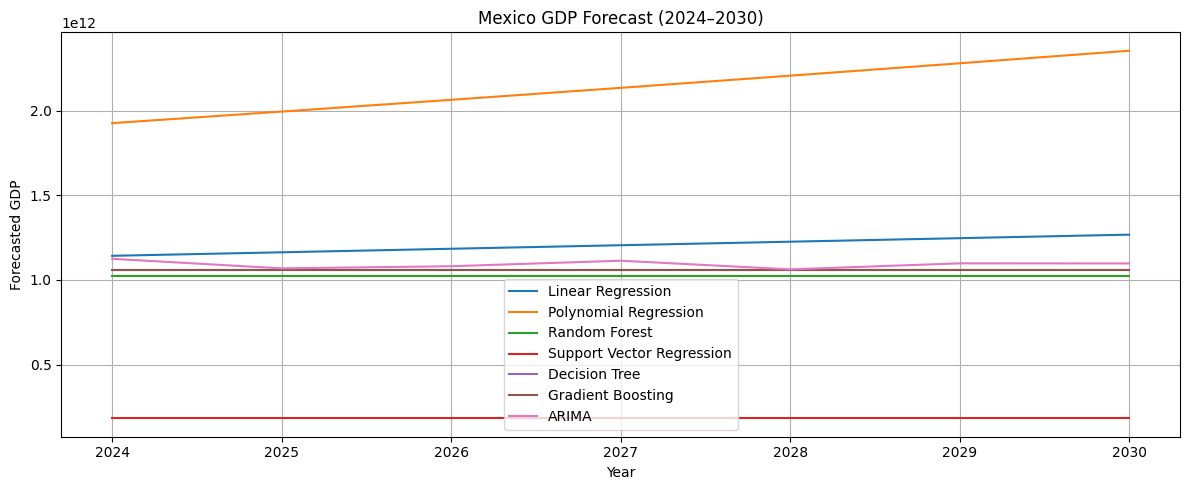

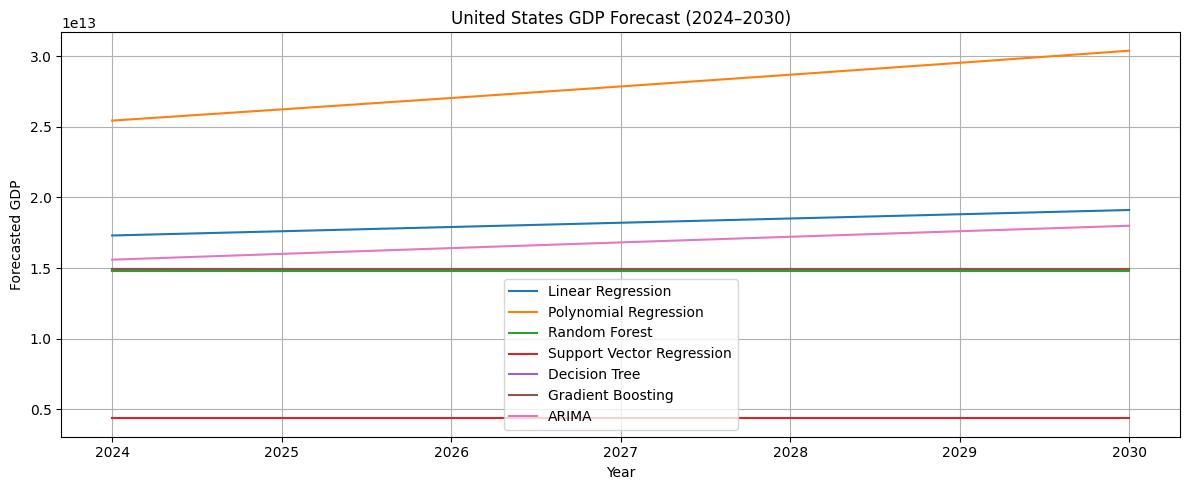

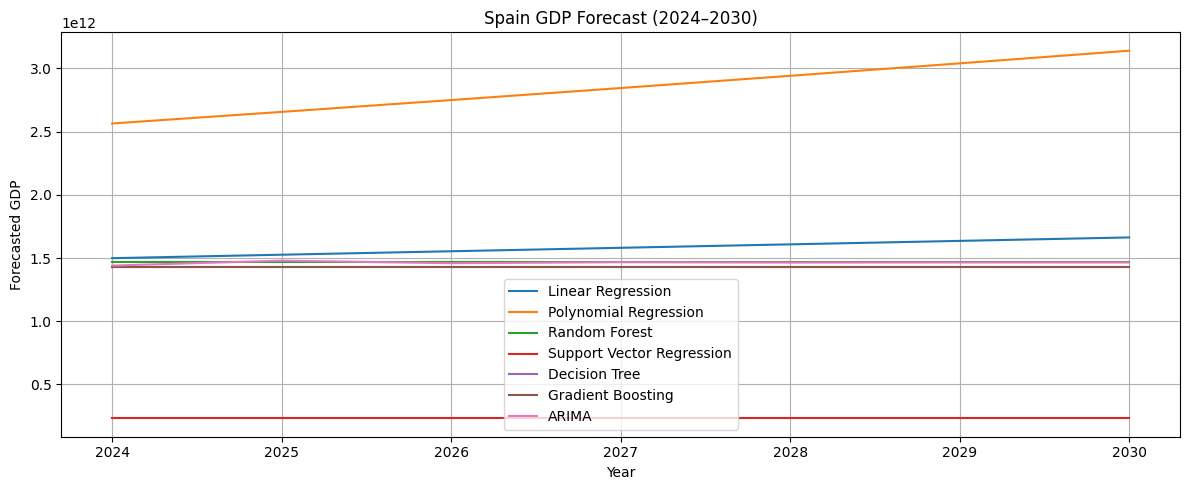

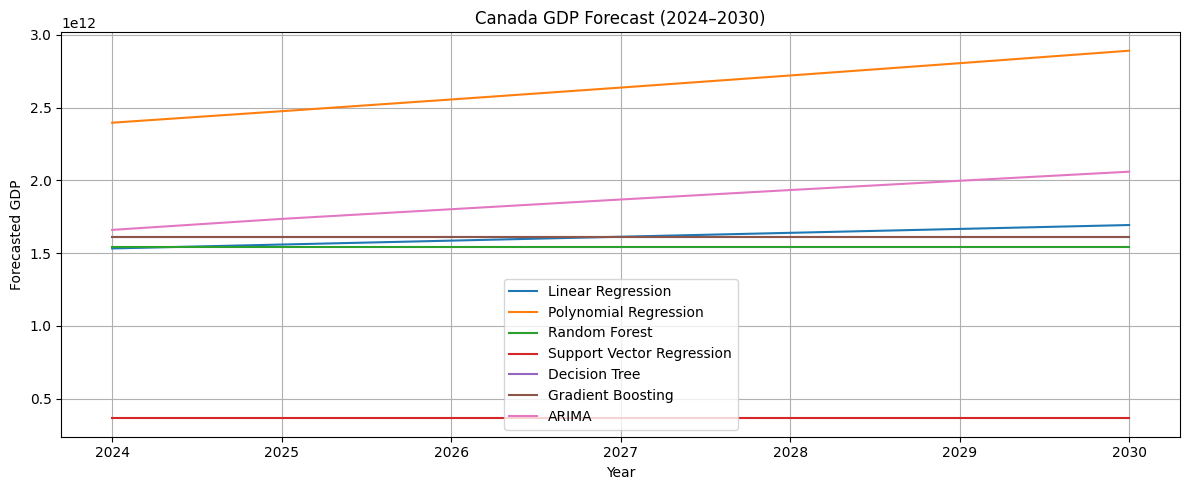

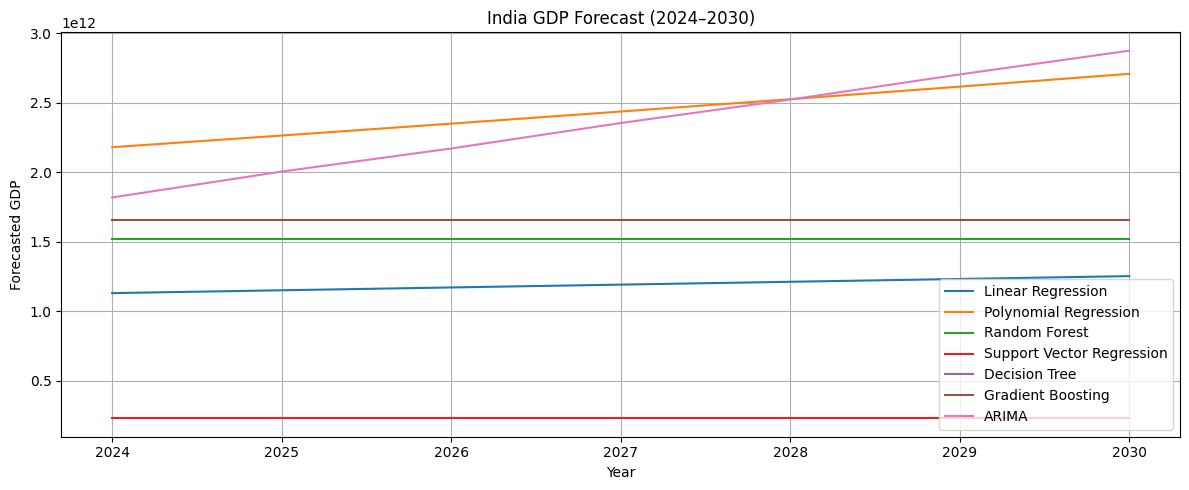

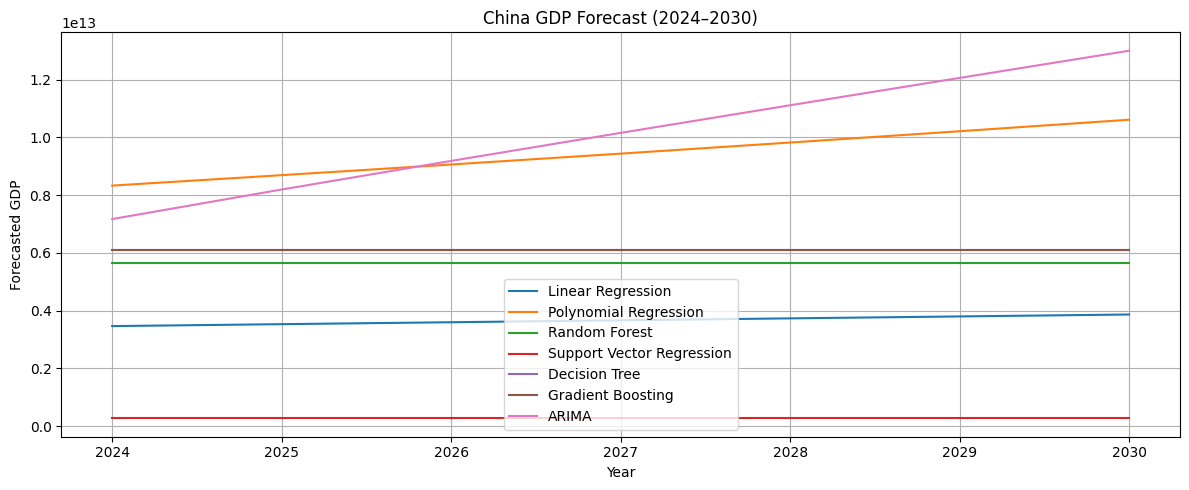

In [1]:

# GDP Forecasting for Multiple Countries using Machine Learning and Time Series Models

# File Path (Local)
data_path = "/Users/pratyushsingh/Downloads/Extended_GDP_2018_2023.csv"

# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv(data_path)
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
df = pd.melt(df, id_vars=id_vars, var_name='year', value_name='GDP')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna()
df['year'] = df['year'].astype(int)
df.rename(columns={'Country Name': 'Country'}, inplace=True)
df = df[['Country', 'year', 'GDP']]

# Target countries
countries = ['Mexico', 'United States', 'Spain', 'Canada', 'India', 'China']
future_years = np.arange(2024, 2031).reshape(-1, 1)

# Models
total_results = []
model_dict = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'Support Vector Regression': SVR(kernel='rbf', C=1e3, gamma=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0)
}

# Model Execution
for country in countries:
    df_country = df[df['Country'] == country].sort_values(by='year')
    X = df_country['year'].values.reshape(-1, 1)
    y = df_country['GDP'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    future_poly = poly.transform(future_years)

    for model_name, model in model_dict.items():
        try:
            if model_name == 'Polynomial Regression':
                model.fit(X_train_poly, y_train)
                preds = model.predict(X_test_poly)
                future_preds = model.predict(future_poly)
            elif model_name == 'Support Vector Regression':
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)

            r2 = r2_score(y_test, preds)

            for i, year in enumerate(future_years.flatten()):
                total_results.append({
                    'Country': country,
                    'Model': model_name,
                    'Year': year,
                    'Forecasted GDP': future_preds[i],
                    'R2 Score': r2
                })

        except Exception as e:
            continue

    # Add ARIMA Model
    try:
        arima_model = ARIMA(y_train, order=(2, 1, 2)).fit()
        arima_forecast = arima_model.forecast(steps=len(future_years))
        arima_preds = arima_model.forecast(steps=len(y_test))
        arima_r2 = r2_score(y_test, arima_preds)

        for i, year in enumerate(future_years.flatten()):
            total_results.append({
                'Country': country,
                'Model': 'ARIMA',
                'Year': year,
                'Forecasted GDP': arima_forecast[i],
                'R2 Score': arima_r2
            })
    except:
        pass

# Create forecast DataFrame
forecast_df = pd.DataFrame(total_results)

# Save to CSV
forecast_df.to_csv("GDP_Forecasts_2024_2030.csv", index=False)

# Visualizations
plt.figure(figsize=(14, 7))
sns.boxplot(data=forecast_df, x='Model', y='R2 Score')
plt.title('R² Score Comparison Across Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line plots for each country
for country in countries:
    plt.figure(figsize=(12, 5))
    subset = forecast_df[forecast_df['Country'] == country]
    for model in subset['Model'].unique():
        model_data = subset[subset['Model'] == model]
        plt.plot(model_data['Year'], model_data['Forecasted GDP'], label=model)
    plt.title(f"{country} GDP Forecast (2024–2030)")
    plt.xlabel("Year")
    plt.ylabel("Forecasted GDP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
